# Anomaly detection

In [126]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from joblib import dump

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

import numpy as np

from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler

In [127]:
X = pd.read_csv("./data/Xtrain.csv")
y = pd.read_csv("./data/y_train.csv")['0']
y_map = y.map({True: -1, False: 1})
X

,thickness_entry,thickness_exit,width,ys_entry,ys_exit,work_roll_diam_1,work_roll_diam_2,work_roll_diam_3,work_roll_diam_4,work_roll_diam_5,...,gap_1,gap_2,gap_3,gap_4,gap_5,motor_power_1,motor_power_2,motor_power_3,motor_power_4,motor_power_5
0,3.7,1.37,935.0,440.0,652.0,546.0,532.0,557.0,581.0,590.0,...,2.249,1.708,1.468,1.262,1.265,4008.853792,4089.339963,4083.372812,3137.888987,2892.033359
1,3.7,1.37,935.0,440.0,652.0,546.0,532.0,557.0,581.0,590.0,...,2.277,1.708,1.430,1.386,1.199,3276.342196,3109.727313,3491.005500,2500.649631,2323.889298
2,3.7,1.37,935.0,440.0,652.0,546.0,532.0,557.0,581.0,590.0,...,2.365,1.719,1.402,1.333,1.269,2285.730212,2590.376867,2644.619756,1814.726609,1698.802991
3,2.5,0.79,1173.0,325.0,568.0,546.0,532.0,557.0,581.0,590.0,...,1.426,0.993,0.784,0.684,0.653,2140.019069,2630.743458,2959.002908,2338.826049,2401.922294
4,2.5,0.79,1173.0,325.0,568.0,546.0,532.0,557.0,581.0,590.0,...,1.354,1.035,0.808,0.665,0.690,2017.459463,2060.444098,2570.144955,2115.648018,2058.297705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16001,3.7,1.37,935.0,440.0,652.0,551.0,539.0,578.0,572.0,580.0,...,2.325,1.753,1.446,1.295,1.260,4648.899060,4378.383444,4657.687193,3534.487171,3501.928357
16002,3.7,1.37,935.0,440.0,652.0,551.0,539.0,578.0,572.0,580.0,...,2.286,1.702,1.384,1.301,1.209,4352.742734,4821.727265,4449.620503,3701.115056,3457.544674
16003,3.7,1.37,935.0,440.0,652.0,551.0,539.0,578.0,572.0,580.0,...,2.305,1.674,1.372,1.328,1.263,3512.383137,3367.519078,3713.153676,2646.503047,2360.511353
16004,3.7,1.37,935.0,440.0,652.0,551.0,539.0,578.0,572.0,580.0,...,2.317,1.732,1.394,1.342,1.267,3988.674043,4532.313087,4316.293941,3039.950614,2867.248213


In [128]:
from collections import Counter

count = Counter(y)
contamination = count[True]/len(y)
print(count)
print(contamination)
y_map

Counter({False: 15220, True: 786})
0.04910658503061352


0        1
1        1
2        1
3        1
4        1
        ..
16001    1
16002    1
16003    1
16004    1
16005    1
Name: 0, Length: 16006, dtype: int64

In [129]:
def plot_3d_scatter(pca_array: np.ndarray, elev: float = 30, azim: float = 45, label: np.ndarray = None):
    """
    Plots a 3D scatter plot from PCA-transformed numpy array.

    Parameters:
    - pca_array (np.ndarray): Numpy array of shape (n_samples, 3), e.g., PCA.fit_transform(X).
    - elev (float): Elevation angle for the 3D view.
    - azim (float): Azimuth angle for the 3D view.
    - label (np.ndarray, optional): Array of labels (e.g., from outlier detection).
                                    Points with label == -1 are colored red, others blue.
    """
    if not isinstance(pca_array, np.ndarray):
        raise TypeError("Input must be a numpy ndarray.")
    if pca_array.shape[1] != 3:
        raise ValueError("Input array must have exactly 3 columns (3 principal components).")
    if label is not None and len(label) != len(pca_array):
        raise ValueError("Label array must be the same length as the number of data points.")

    x, y, z = pca_array[:, 0], pca_array[:, 1], pca_array[:, 2]

    # Determine colors based on label
    if label is not None:
        colors = np.where(label == -1, 'red', 'blue')
    else:
        colors = 'dodgerblue'

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=colors, s=50)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("3D PCA Scatter Plot")

    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()

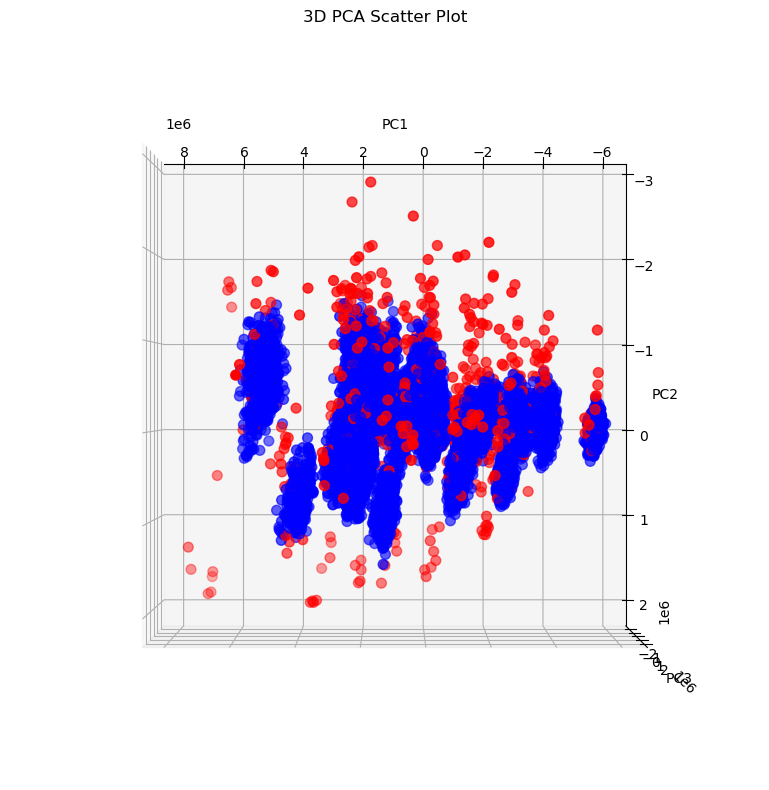

In [130]:
pca = PCA(n_components=3)
X_tovis = pca.fit_transform(X)

plot_3d_scatter(X_tovis, 90,90, label=y_map)

# <span style="color:green"> Unsupervised
Tutaj w zasadzie staram sie samemu to zrobic, to jest jak jeszcze etykiet nie mielismy, ale okazuje sie ze DBSCAN, bardzo fajnie to wyłapał :DD

# Isolation Forest

[-1  1 -1 ...  1 -1 -1]


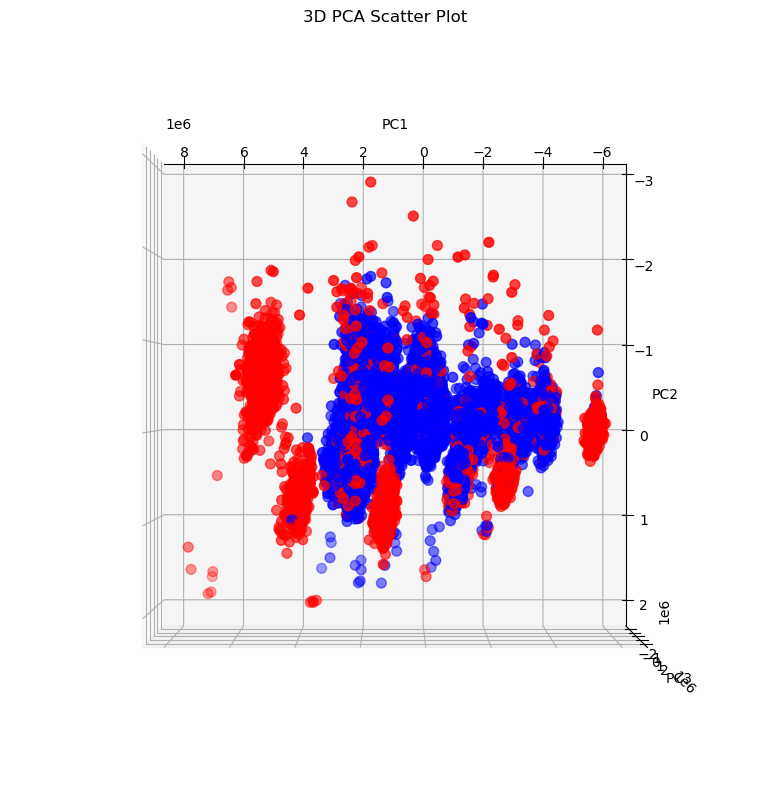

In [131]:
model = IsolationForest(n_estimators=200)
model.fit(X)
outlays = model.predict(X)
print(outlays)
plot_3d_scatter(X_tovis, 90,90,label=outlays)

# DBSCAN

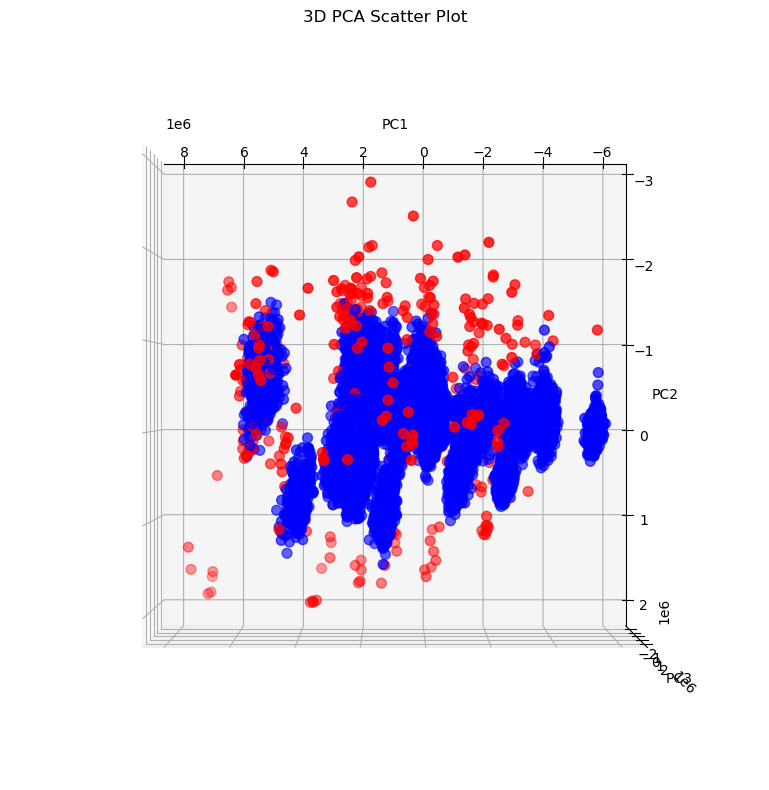

In [132]:
# 1 000 000
model = DBSCAN(eps=410000, min_samples=15)
model.fit(X)
labels = model.labels_
plot_3d_scatter(X_tovis, 90,90,label=labels)

## LOF

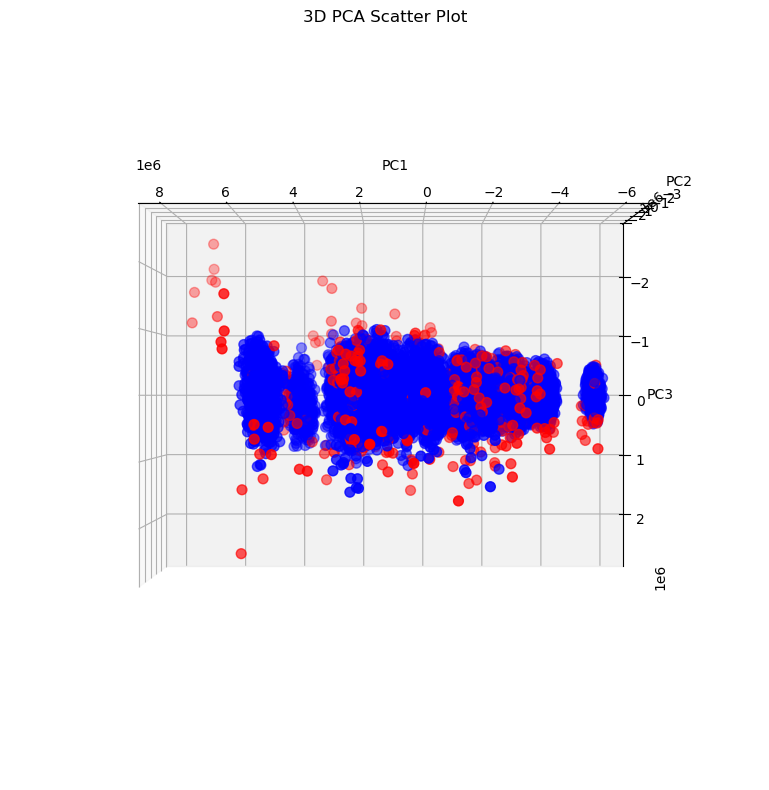

In [133]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20)
labels = clf.fit_predict(X)  # -1: anomalia, 1: normalny
plot_3d_scatter(X_tovis, 180,90,label=labels)

# LOF + DBSCAN

In [134]:
def combine_labels(labelset_1: pd.Series, labelset_2: pd.Series):

    l_new = []
    for l1, l2 in zip(labelset_1, labelset_2):
        if l1 == -1 or l2 == -1:
            l_new.append(-1)
        else:
            l_new.append(0)
    return np.array(l_new)

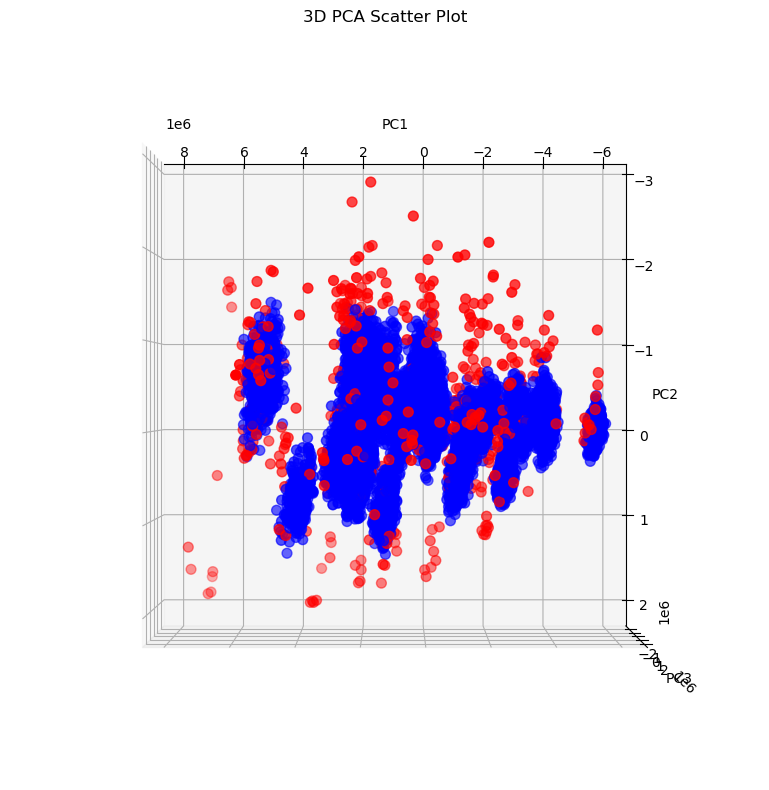

In [135]:
model1 = DBSCAN(eps=410000, min_samples=15)
model2 = LocalOutlierFactor(n_neighbors=20)

labels1 = model1.fit_predict(X)
labels2 = model2.fit_predict(X)

labels = combine_labels(labels1, labels2)

plot_3d_scatter(X_tovis, 90,90,label=labels)

# Autoencoder :DDD

In [136]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

clean_X = X[~y]
outline_X = X[y]
clean_X

array([[ 1.09995498,  0.77713478, -1.19493458, ...,  2.32385672,
         2.03198076,  1.92437713],
       [ 1.09995498,  0.77713478, -1.19493458, ...,  1.22097583,
         0.38837223,  0.19944321],
       [ 1.09995498,  0.77713478, -1.19493458, ..., -0.35484149,
        -1.38080434, -1.69837223],
       ...,
       [ 1.09995498,  0.77713478, -1.19493458, ...,  1.63457559,
         0.76456669,  0.3106309 ],
       [ 1.09995498,  0.77713478, -1.19493458, ...,  2.75751377,
         1.77937184,  1.84912731],
       [ 1.09995498,  0.77713478, -1.19493458, ...,  3.97882549,
         2.66128588,  3.05093973]], shape=(15220, 51))

In [137]:
outline_X

array([[ 0.20393587,  0.12313763,  0.4744695 , ...,  1.2720594 ,
         1.18929106,  0.23359069],
       [-1.58810234, -1.21927758,  0.77198706, ...,  0.38386522,
         0.47064472,  0.68695431],
       [ 1.32395976,  1.74092006,  0.87115958, ..., -1.23894497,
        -1.35823392, -1.58163689],
       ...,
       [ 0.20393587,  0.15755853, -0.81477325, ..., -1.30882792,
        -0.98134356, -1.26347728],
       [-1.14009279, -1.18485668, -0.39329005, ...,  1.43499326,
         1.60277158,  0.73283575],
       [-0.24407368, -0.46201772, -0.07924373, ..., -0.09154241,
         0.3302616 ,  0.10374584]], shape=(786, 51))

In [173]:
model = MLPRegressor(hidden_layer_sizes=(30,20,3,20,30), max_iter=20, activation='tanh', solver='sgd', batch_size=6, verbose=True, learning_rate='adaptive')
model.fit(clean_X, clean_X)

Iteration 1, loss = 0.15041058
Iteration 2, loss = 0.12843814
Iteration 3, loss = 0.12409332
Iteration 4, loss = 0.12201385
Iteration 5, loss = 0.12099836
Iteration 6, loss = 0.12035321
Iteration 7, loss = 0.11988607
Iteration 8, loss = 0.11948087
Iteration 9, loss = 0.11906410
Iteration 10, loss = 0.11861425
Iteration 11, loss = 0.11816957
Iteration 12, loss = 0.11776669
Iteration 13, loss = 0.11736364
Iteration 14, loss = 0.11704186
Iteration 15, loss = 0.11667285
Iteration 16, loss = 0.11642987
Iteration 17, loss = 0.11621390
Iteration 18, loss = 0.11597986
Iteration 19, loss = 0.11573046
Iteration 20, loss = 0.11548031


/opt/miniconda3/envs/bobot_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', batch_size=6,
             hidden_layer_sizes=(30, 20, 3, 20, 30), learning_rate='adaptive',
             max_iter=20, solver='sgd', verbose=True)

In [174]:
mse_func = lambda x,y: np.mean(np.power(x - y, 2), axis=1)

reconstructed_X_test = model.predict(clean_X)
mse = mse_func(clean_X, reconstructed_X_test)
threshold = np.percentile(mse, 95)
print(f"95% percentyle: {threshold}")

95% percentyle: 0.3271175165819042


In [175]:
reconstructed_outline = model.predict(outline_X)
mse_out = mse_func(outline_X, reconstructed_outline)
out_val = mse_out > threshold
print(Counter(out_val))

0.20241650793733185
0.2662389839192681
0.31149132132403906
0.24496956506406076
0.32189566547326415
0.31791023382545097
0.276222150886113
0.2801366360341427
0.314889357214379
0.316450158930723
0.2848422960786664
0.27689783713775296
0.275151032005756
0.25054007093903863
0.253562033347227
0.3161055010697799
0.30389494893620206
0.3259278152455755
0.30131170226361104
0.2619182731009057
0.3141999680535498
0.27734078776281135
0.2629436531788337
0.30152178412414954
0.22496564685306708
0.2934367045793203
0.2736241044695457
0.2760974645279059
0.293503172704008
0.21218719653215992
0.2380146855093375
0.26742185097536647
0.16055354224345894
0.1478837667094188
0.1401836661227892
0.16775942222738144
0.21197531911919676
0.29077798577193475
0.2885897591518931
0.26762294329786934
0.26608375059373474
0.2888311994795513
0.25803441519383136
0.2655800104707531
0.25794381483258677
0.25282850852770045
0.2755050377653706
0.31506325078761044
0.2730360649353657
0.2463425814191942
0.22467550660275334
0.2261719319

> thats good

In [176]:
dump(scaler, 'scaler.joblib')
dump(model, "autoencoder.joblib")
dump(threshold, 'threshold.joblib')

['threshold.joblib']